https://github.com/freedaemons/hwz-scrape

In [2]:
import requests as re
import pandas as pd
import numpy as np
import seaborn as sns
import os
from bs4 import BeautifulSoup
from datetime import datetime
from matplotlib import pyplot as plt

In [ ]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [ ]:
def getThreads(forum_url,forum_df):
    lastForumPage = False
    # forum_cols = ['forum_url', 'thread', 'thread_url']
    # forum_df = pd.DataFrame(columns=forum_cols)
    forum_page_url = forum_url
    while(not lastForumPage):
        r2 = re.get(forum_page_url)
        forum_page = r2.text
        forum_page_soup = BeautifulSoup(forum_page, 'html.parser')

        if (forum_page_soup.find('a', text='Next ›') == None):
            lastForumPage = True
        else:
            forum_page_url = site_url + forum_page_soup.find('a', text='Next ›')['href']

        for element in forum_page_soup.find_all('a', {"id": lambda x: x and 'thread_title_' in x}):
            row = pd.DataFrame([[forum_url, element.contents[0], site_url + element['href']]], columns=forum_cols)
            if(len(forum_df)==0):
                forum_df = row
            else:
                forum_df = forum_df.append(row, ignore_index=True) #df.append doesn't work inplace
    return forum_df

Relevant Forums to get neighbourhood sentiment

https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/



In [ ]:
relevant_threads = ['https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/']

site_url = 'https://forums.hardwarezone.com.sg'                    

In [ ]:
%%time
forum_cols = ['forum_url', 'thread', 'thread_url']
forum_df = pd.DataFrame(columns=forum_cols)

for link in relevant_threads:
  forum_df = getThreads(link,forum_df)

CPU times: user 4.99 s, sys: 62.2 ms, total: 5.05 s
Wall time: 41.6 s


In [ ]:
forum_df.loc[forum_df['forum_url'] == 'https://forums.hardwarezone.com.sg/homeseekers-homemakers-74/' ,'forum'] = 'homeseekers-homemakers'

In [ ]:
print(len(forum_df))

1360


In [ ]:
forum_no_emoji = forum_df.copy()

In [ ]:
import re as rec

In [ ]:
#Remove emoji before saving to csv file or will have encode error
# https://zhuanlan.zhihu.com/p/41213713

def remove_emoji(text):

    myre = rec.compile(u'[\ud83c'
                      u'\ud83d]+'
                      , re.UNICODE)
  
    text = myre.sub(' ', text)
    return text
        
forum_no_emoji['thread'] = forum_no_emoji['thread'].apply(remove_emoji)

In [ ]:
forum_no_emoji.to_csv("allthreads.csv", encoding='utf-8', index=False)

In [ ]:
allThreads_df = pd.read_csv('/content/drive/MyDrive/BT4222 WEISHENG/Generated csv/hwz/allthreads.csv')
print(len(allThreads_df))
allThreads_df.head()

713


forum_url  ...                   forum
0  https://forums.hardwarezone.com.sg/homeseekers...  ...  homeseekers-homemakers
1  https://forums.hardwarezone.com.sg/homeseekers...  ...  homeseekers-homemakers
2  https://forums.hardwarezone.com.sg/homeseekers...  ...  homeseekers-homemakers
3  https://forums.hardwarezone.com.sg/homeseekers...  ...  homeseekers-homemakers
4  https://forums.hardwarezone.com.sg/homeseekers...  ...  homeseekers-homemakers

[5 rows x 4 columns]

In [ ]:
allThreads_df['thread'] = allThreads_df['thread'].str.replace(r'\r|\n|\t',' ')

In [ ]:
#Remove GAGT/PCWX app automatic signatures
allThreads_df['thread'].replace(r'Sent from .* using GAGT', '', inplace = True, regex=True) 
allThreads_df['thread'].replace(r'Posted from PCWX using .*', '', inplace = True, regex=True) 
# ^^ will not remove the entire phone model but as much as possible try 
allThreads_df['thread'].replace(r'Posted with .* via PCWX', '', inplace = True, regex=True)

In [ ]:
allThreads_df['thread'] = allThreads_df['thread'].apply(lambda x: ' '.join([word.lower() for word in str(x).split()])) 

In [ ]:
allThreads_df['thread'].replace('', np.nan, inplace = True) #replace empty strings with NaN
allThreads_df.dropna(inplace = True) #Drop NaN rows (originally empty strings)

In [ ]:
allThreads_df['thread'].size

713

In [ ]:
def getPosts(thread_url):
    #print(thread_url)
    lastThreadPage = False
    thread_cols = ['thread_url', 'userid', 'timestamp', 'post_text', 'post_number', 'post_id', 'first_quote_post_number'] # 'likes_userid'
    thread_df = pd.DataFrame(columns=thread_cols)
    thread_page_url = thread_url

    while (not lastThreadPage):

        r3 = re.get(thread_page_url)
        thread_page = r3.text
        thread_page_soup = BeautifulSoup(thread_page, 'html.parser')

        if (thread_page_soup.find('a', text='Next ›') == None):
            lastThreadPage = True
        else:
            thread_page_url = site_url + thread_page_soup.find('a', text='Next ›')['href']

        thread_page_posts = thread_page_soup.find('div', {'id': 'posts'})
        
        try: 
            for post in thread_page_posts.find_all('div', {'class': 'post-wrapper'}):
                userid_url = post.find('a', {'class': 'bigusername'})['href']
                userid = ''.join(filter(lambda x: x.isdigit(), userid_url))

                datetime_raw = post.find('a', {'name': lambda x: x and x.find('post') == 0}).nextSibling.strip()
                date_list = datetime_raw.split(',')[0].split('-')
                iso_date = '-'.join(list(reversed(date_list)))
                hour = int(datetime_raw.split(' ')[1][0:2])
                if(datetime_raw.split(' ')[2] == 'PM' and hour < 12):
                    hour += 12
                hour_str = str(hour)
                if(hour < 10):
                    hour_str = '0' + str(hour)
                minute = datetime_raw.split(':')[1][0:2]
                iso_datetime = iso_date + 'T' + hour_str + ':' + minute

                post_text = ""
                try:
                    post_text = post.find('div', {'class': 'post_message'}).get_text(' ', strip=True)
                except AttributeError as e: 
                    pass

                post_number = int(post.find('a', {'id': lambda x: x and 'postcount' in x, 'target': 'new'}).find('strong').get_text())

                post_id = int(post.find('a', {'id': lambda x: x and 'postcount' in x, 'target': 'new'})['id'].lstrip('postcount'))
                
                first_quote_post_number = np.nan
                try:
                    first_quote = post.find('div', {'class': 'quote'})
                    first_quote_post_number = first_quote.find('span', {'class': 'byline'}).find('a')['href'].split('#')[1].lstrip('post')
                except:
                    pass
                
                row = pd.DataFrame([[thread_url, userid, iso_datetime, post_text, post_number, post_id, first_quote_post_number]], columns=thread_cols)
                if(len(thread_df)==0):
                    thread_df = row
                else:
                    thread_df = thread_df.append(row, ignore_index=True) #df.append doesn't work inplace
        except:
            row = pd.DataFrame([[thread_url, "", "", "", np.nan, np.nan, np.nan]], columns=thread_cols) #posts missing, thread may have been deleted
            if(len(thread_df)==0):
                thread_df = row
            else:
                thread_df = thread_df.append(row, ignore_index=True) #df.append doesn't work inplace
    thread_df['post_text'] = thread_df['post_text'].map(lambda x: x.encode('unicode-escape').decode('utf-8'))

    return thread_df

In [ ]:
links = allThreads_df['thread_url']

In [ ]:
%%time
thread_cols = ['thread_url', 'userid', 'timestamp', 'post_text', 'post_number', 'post_id', 'first_quote_post_number'] # 'likes_userid'
all_comments_df = pd.DataFrame(columns=thread_cols)

for i in links:
  post = getPosts(i)
  all_comments_df = all_comments_df.append(post, ignore_index=True)

In [ ]:
# all_comments_df['post_text'] = all_comments_df['post_text'].apply(remove_emoji)
all_comments_df.to_csv("all_thread_links.csv", encoding='utf-8', index=False)

In [ ]:
from google.colab import files
files.download("all_thread_links.csv") 

Preprocess all comments csv file


In [4]:
all_comments_df = pd.read_csv('/content/drive/MyDrive/BT4222 WEISHENG/Generated csv/hwz/all_thread_links.csv')
print(len(all_comments_df))
all_comments_df.head()

95877


thread_url  ...  first_quote_post_number
0  https://forums.hardwarezone.com.sg/homeseekers...  ...                      NaN
1  https://forums.hardwarezone.com.sg/homeseekers...  ...                      NaN
2  https://forums.hardwarezone.com.sg/homeseekers...  ...              131803016.0
3  https://forums.hardwarezone.com.sg/homeseekers...  ...              131803016.0
4  https://forums.hardwarezone.com.sg/homeseekers...  ...                      NaN

[5 rows x 7 columns]

In [ ]:
all_comments_df['post_text'].isnull().values.any()

True

In [ ]:
all_comments_df = all_comments_df[all_comments_df['post_text'].notna()]
all_comments_df['post_text'].isnull().values.any()
print(len(all_comments_df))

95693


In [ ]:
postal_district_num = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
general_location = [['Raffles Place', 'Cecil', 'Marina', "People\'s Park", "Boat Quay", "Chinatown", "Havelock Road", "Suntec City"],
                    ['Anson', 'Tanjong Pagar', 'Neil Road', "Shenton Way"],
                    ['Bukit Merah', 'Queenstown', 'Tiong Bahru', "Alexandra Road"],
                    ['Telok Blangah', 'Harbourfront', 'Keppel', "Mount Faber", "Sentosa"],
                    ['Buona Vista', 'Dover', 'Pasir Panjang', "West Coast", "Hong Leong Garden", "Clementi"],
                    ['High Street', 'Beach Road', 'City Hall', "North Bridge Road"],
                    ['Middle Road', 'Golden Mile', 'Bencoolen Road', "Bugis", "Rochor"],
                    ['Little India', 'Farrer Park', 'Jalan Besar', "Lavender"],
                    ['Orchard', 'Cairnhill', 'River Valley', "Killiney", "Leonie Hill", "Oxley"],
                    ['Ardmore', 'Bukit Timah', "Balmoral", "Boat Quay", "Grange Road", "Holland", "Tanglin"],
                    ['Watten Estate', 'Thomson', "Chancery", "Bukit Timah", "Dunearn Road", "Newton"],
                    ['Balestier', 'Moulmein', 'Novena', "Toa Payoh", "Serangoon"],
                    ['Macpherson', 'Braddell', 'Potong Pasir', "Bidadari"], 
                    ['Geylang', 'Eunos', 'Kembangan', "Paya Lebar", "Aljunied"], 
                    ['Katong', 'Joo Chiat', 'Amber Road', "Marine Parade", "Siglap", "Tanjong Rhu"],
                    ['Bedok', 'Upper East Coast', 'Eastwood', "Kew Drive", "Bayshore", "Chai Chee"], 
                    ['Loyang', 'Changi'],
                    ['Simei', 'Tampines', 'Pasir Ris'],
                    ['Serangoon Garden', 'Hougang', 'Punggol', 'Sengkang'],
                    ['Ang Mo Kio', 'Bishan', 'Braddell Road', "Thomson"],
                    ['Upper Bukit Timah', 'Ulu Pandan', "Hume Avenue"],
                    ['Penjuru', 'Jurong', 'Pioneer', "Tuas", "Boon Lay"],
                    ['Hillview', 'Dairy Farm', 'Bukit Panjang', "Choa Chu Kang", "Bukit Batok"], 
                    ['Lim Chu Kang', 'Tengah', 'Kranji', "Sungei Gedong"], 
                    ['Woodgrove', 'Woodlands', 'Admiralty','Kranji'],
                    ['Upper Thomson', 'Springleaf', 'Tagore', "Yio Chu Kang"],
                    ['Yishun', 'Sembawang', 'Senoko'],
                    ['Seletar']]

postal_district = {postal_district_num[i]: general_location[i] for i in range(len(postal_district_num))}   

Data- Preprocessing


In [ ]:
import re
#Remove duplicate rows
all_comments_df['post_id'].drop_duplicates(inplace=True)
#Remove GAGT/PCWX app automatic signatures
all_comments_df['post_text'].replace(r'Sent from .* using GAGT', '', inplace = True, regex=True) 
all_comments_df['post_text'].replace(r'Posted from PCWX using .*', '', inplace = True, regex=True) 
# ^^ will not remove the entire phone model but as much as possible try 
all_comments_df['post_text'].replace(r'Posted with .* via PCWX', '', inplace = True, regex=True)
#Remove Links
all_comments_df['post_text'] = all_comments_df['post_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

Finding all relevant comments that contains name of each location in each district and assigning a district number


In [ ]:
%%time
thread_cols = ['thread_url', 'userid', 'timestamp', 'post_text', 'post_number', 'post_id', 'first_quote_post_number','district_num'] # 'likes_userid'
all_comments_relevant = pd.DataFrame(columns=thread_cols)

for key, values in postal_district.items():
  temp_df = all_comments_df[all_comments_df['post_text'].str.contains('|'.join(values), case=False)]   #not case sensitive
  temp_df['district_num'] = key
  all_comments_relevant = all_comments_relevant.append(temp_df, ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


CPU times: user 1min 1s, sys: 75.3 ms, total: 1min 1s
Wall time: 1min 1s


In [ ]:
all_comments_relevant.district_num.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28], dtype=object)

In [ ]:
all_comments_relevant.groupby('district_num')['post_id'].nunique().sort_values(ascending=False)

district_num
19    3341
18    2471
14    1564
5     1491
27    1378
12    1047
20     959
25     896
13     875
10     739
11     679
23     666
22     628
24     601
4      537
16     486
9      448
3      446
17     434
1      365
7      269
15     268
28     159
8      115
2      114
21      92
6       59
26      55
Name: post_id, dtype: int64

In [ ]:
all_comments_relevant.to_csv("all_relevant_comments_without_preprocessing.csv", encoding='utf-8', index=False)

Load csv file with all the relevant comments for sentiment analysis

In [3]:
all_comments_relevant = pd.read_csv('/content/drive/MyDrive/BT4222 WEISHENG/Generated csv/hwz/all_relevant_comments_without_preprocessing.csv')
all_comments_relevant.shape

(21218, 8)

In [7]:
hwz_vader = all_comments_relevant.copy()

In [8]:
# add sentiment anaylsis columns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
hwz_vader["sentiments"] = hwz_vader["post_text"].apply(lambda x: sid.polarity_scores(x))
hwz_vader = pd.concat([hwz_vader.drop(['sentiments'], axis=1), hwz_vader['sentiments'].apply(pd.Series)], axis=1)

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
average_negative = hwz_vader["neg"].mean()
average_negative

0.041357715147515996

In [ ]:
average_positive = hwz_vader["pos"].mean()
average_positive

0.09875615043830767

In [ ]:
average_neutral = hwz_vader["neu"].mean()
average_neutral

0.8598839664435923

In [ ]:
average_compound = hwz_vader["compound"].mean()
average_compound

0.38512390423225856

Results for Level of Positivity

86% neutral comments
9.9% positive comments
4.1% negative comments
Compound score = 38.5%

In [ ]:
district = hwz_vader.district_num.unique().tolist()
district.sort()

In [ ]:
district_num = []
compound_values = []
for d in district:
  temp_df = hwz_vader.loc[hwz_vader['district_num'].isin([d])]
  district_num.append(d)
  compound_score = temp_df.compound.mean()
  compound_values.append(compound_score) 


district_df = pd.DataFrame({'district_num': district_num ,'mean_compound': compound_values})

In [ ]:
top_5 = district_df.sort_values(by=['mean_compound'], ascending=False)[:5]
top_5

district_num  mean_compound
1              2       0.507043
14            15       0.476704
2              3       0.471499
8              9       0.464937
20            21       0.463515

In [ ]:
btm_5 = district_df.sort_values(by=['mean_compound'], ascending=True)[:5]
btm_5

district_num  mean_compound
24            25       0.238839
26            27       0.333701
7              8       0.349713
18            19       0.354476
23            24       0.355492

In [ ]:
# highest positive sentiment reviews
hwz_vader.sort_values("pos", ascending = False)[["comment_body", "pos"]].head(10)

post_text    pos
17075                                I love jurong.... Y  0.808
8043                                         geylang ftw  0.750
11184                           Woohoo, tampines 156!!!!  0.691
17111                                 Great jurong sale!  0.687
17627                              Bukit Panjang hahaha.  0.643
11763  I applied for Tampines 3 room and my queue num...  0.629
14318  alexljh86 wrote: I applied Punggol. Wish Lucky...  0.600
11189  gravityz3r0 wrote: Woohoo, tampines 156!!!! Wa...  0.589
18635          Pretty happy applied for tengah queue 40+  0.580
20802  Please show yishun some love lol Perisher wrot...  0.571

In [ ]:
# highest lowest sentiment reviews
hwz_vader.sort_values("neg", ascending = False)[["post_text", "neg"]].head(10)

post_text    neg
19828  Shock die. Woodlands bto 7 years wait \U0001f6...  0.565
18678                   sadly no longer after tengah bto  0.556
10834  Q bay murder and suicide and foreign worker fe...  0.483
15113  holasingapura wrote: Man arrested over alleged...  0.478
15111  Man arrested over alleged murder in Sengkang c...  0.464
8697   daheigou999 wrote: I hate Aljunied area, but 1...  0.438
7579                           don't find eunos/ubi nice  0.437
8032                      wtf that geylang one satki man  0.432
2021   anybody can give some idea on clementi peaks b...  0.432
5931   282 reply. Condo also suffer lease problems. W...  0.431

In [9]:
#Getting comments from 2018 to 2021
year_2018 = hwz_vader[hwz_vader['timestamp'].str.contains("2018")] 
year_2019 = hwz_vader[hwz_vader['timestamp'].str.contains("2019")] 
year_2020 = hwz_vader[hwz_vader['timestamp'].str.contains("2020")] 
year_2021 = hwz_vader[hwz_vader['timestamp'].str.contains("2021")]

In [10]:
#Change in compound sentiment over the years
average_compound_2018 = year_2018["compound"].mean()
average_compound_2019 = year_2019["compound"].mean()
average_compound_2020 = year_2020["compound"].mean()
average_compound_2021 = year_2021["compound"].mean()

print("average_compound_2018 : ", average_compound_2018)
print("average_compound_2019 : ", average_compound_2019)
print("average_compound_2020 : ", average_compound_2020)
print("average_compound_2021 : ", average_compound_2021)

average_compound_2018 :  0.3026460757156043
average_compound_2019 :  0.40815820895522403
average_compound_2020 :  0.40560363578880726
average_compound_2021 :  0.3559378825475608


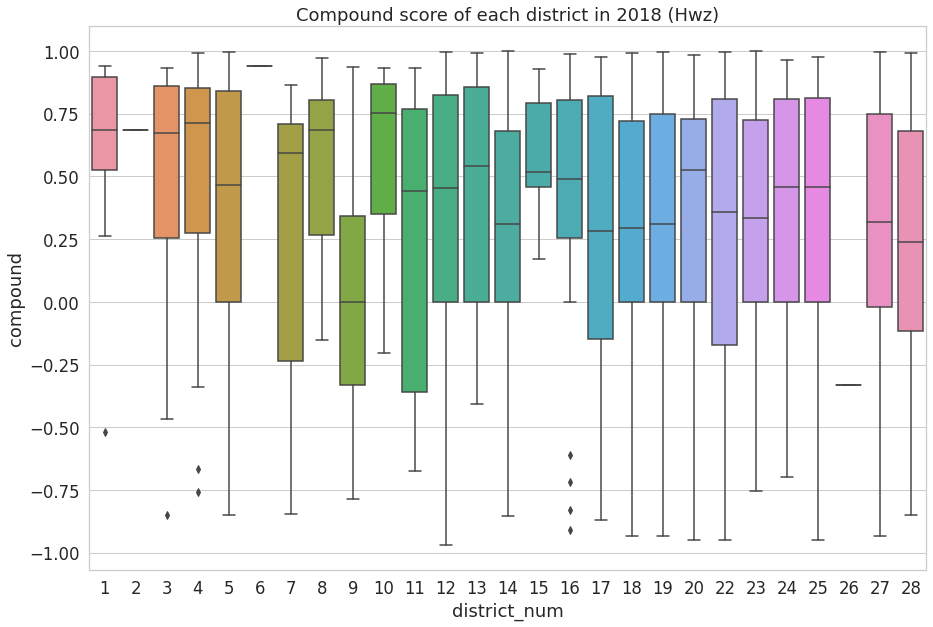

In [11]:
sns.set(rc={'figure.figsize':(15,10)}, font_scale=1.5, style='whitegrid')

sns.boxplot(x="district_num", y="compound", data=year_2018).set_title('Compound score of each district in 2018 (Hwz)');

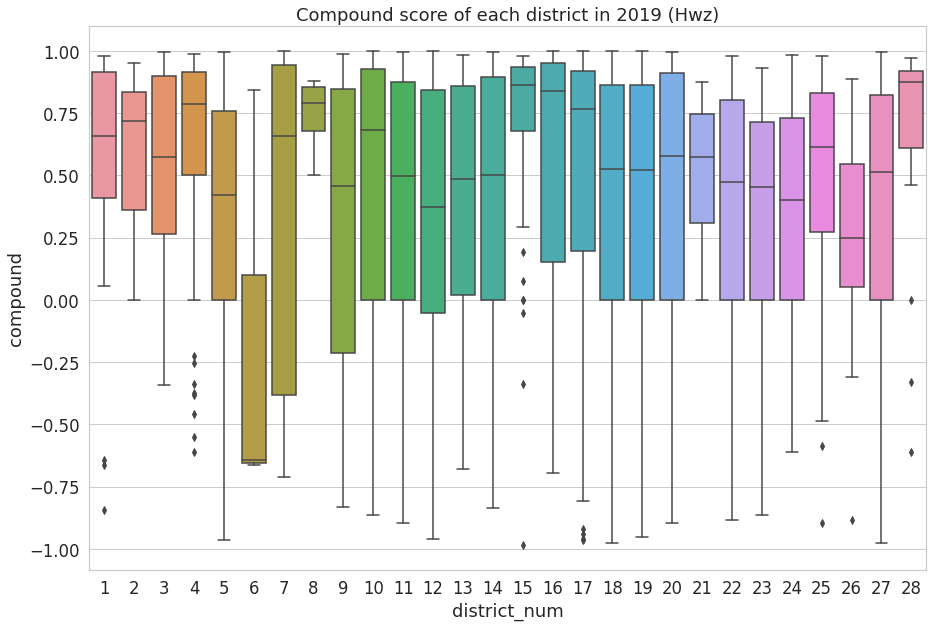

In [12]:
sns.set(rc={'figure.figsize':(15,10)}, font_scale=1.5, style='whitegrid')

sns.boxplot(x="district_num", y="compound", data=year_2019).set_title('Compound score of each district in 2019 (Hwz)');

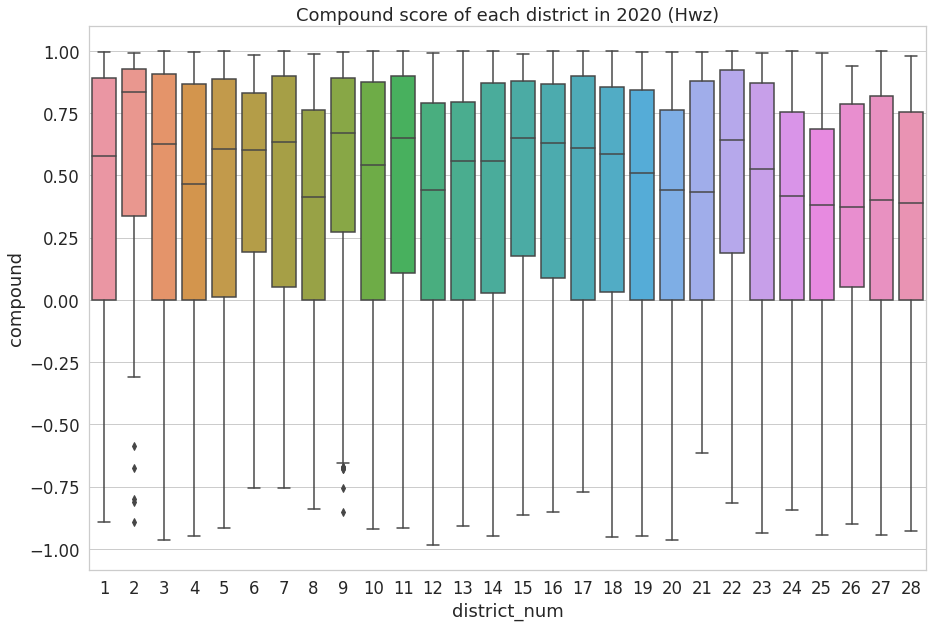

In [13]:
sns.set(rc={'figure.figsize':(15,10)}, font_scale=1.5, style='whitegrid')

sns.boxplot(x="district_num", y="compound", data=year_2020).set_title('Compound score of each district in 2020 (Hwz)');

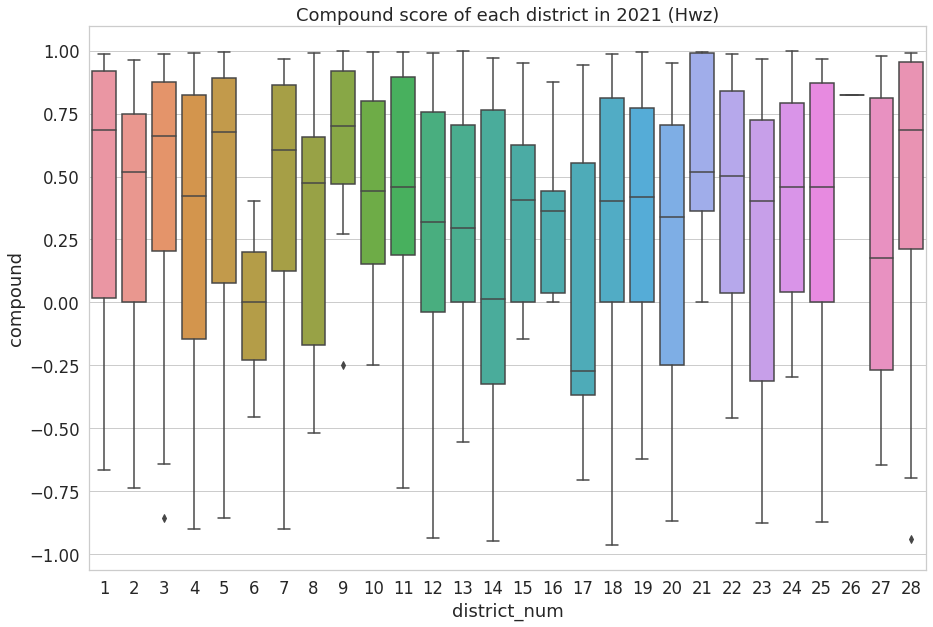

In [14]:
sns.set(rc={'figure.figsize':(15,10)}, font_scale=1.5, style='whitegrid')

sns.boxplot(x="district_num", y="compound", data=year_2021).set_title('Compound score of each district in 2021 (Hwz)');

Grouping and finding the mean sentiment score by district number

In [15]:
#2018
comment_count_2018 = year_2018.groupby('district_num')['post_id'].nunique().sort_values(ascending=False)
comment_count_2018  = pd.DataFrame(comment_count_2018)
mean_district_sentiment_2018 = year_2018.groupby('district_num', as_index=False)['compound'].mean()

sentiment_2018 = mean_district_sentiment_2018.merge(comment_count_2018, on='district_num', how='left')
sentiment_2018.columns = ['district_num', 'compound_sentiment', 'comment_count']
sentiment_2018['year'] = 2018

In [16]:
#2019
comment_count_2019 = year_2019.groupby('district_num')['post_id'].nunique().sort_values(ascending=False)
comment_count_2019  = pd.DataFrame(comment_count_2019)
mean_district_sentiment_2019 = year_2019.groupby('district_num', as_index=False)['compound'].mean()

sentiment_2019 = mean_district_sentiment_2019.merge(comment_count_2019, on='district_num', how='left')
sentiment_2019.columns = ['district_num', 'compound_sentiment', 'comment_count']
sentiment_2019['year'] = 2019

In [17]:
#2020
comment_count_2020 = year_2020.groupby('district_num')['post_id'].nunique().sort_values(ascending=False)
comment_count_2020 = pd.DataFrame(comment_count_2020)
mean_district_sentiment_2020 = year_2020.groupby('district_num', as_index=False)['compound'].mean()

sentiment_2020 = mean_district_sentiment_2020.merge(comment_count_2020, on='district_num', how='left')
sentiment_2020.columns = ['district_num', 'compound_sentiment', 'comment_count']
sentiment_2020['year'] = 2020

In [18]:
#2021
comment_count_2021 = year_2021.groupby('district_num')['post_id'].nunique().sort_values(ascending=False)
comment_count_2021 = pd.DataFrame(comment_count_2021)
mean_district_sentiment_2021 = year_2021.groupby('district_num', as_index=False)['compound'].mean()

sentiment_2021 = mean_district_sentiment_2021.merge(comment_count_2021, on='district_num', how='left')
sentiment_2021.columns = ['district_num', 'compound_sentiment', 'comment_count']
sentiment_2021['year'] = 2021

In [ ]:
sentiment_list = [sentiment_2018, sentiment_2019, sentiment_2020, sentiment_2021]  # List of your dataframes
hwz_vader_sentiment = pd.concat(sentiment_list)

In [ ]:
hwz_vader_sentiment.to_csv("hwz_vader_sentiment.csv", encoding='utf-8', index=False)

Generating WordCloud and Topic-Modelling

Pre-processing

In [4]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
all_comments_relevant['post_text'] = all_comments_relevant['post_text'].apply(lambda x: clean_text(x))

/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. D

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


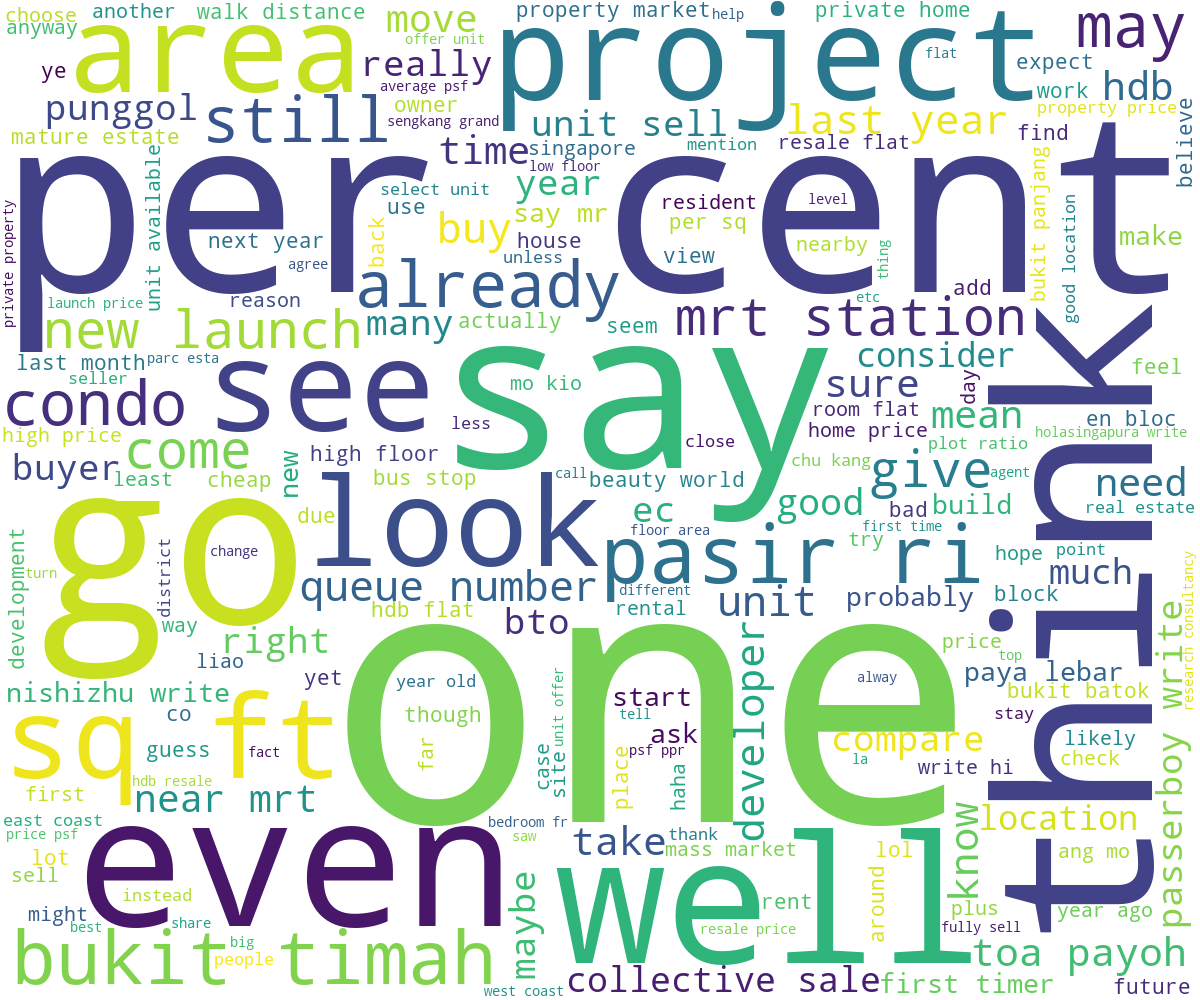

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Join the different processed titles together.
long_string = ','.join(list(all_comments_relevant["post_text"].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", stopwords = STOPWORDS, width=1200, height=1000, max_words=200, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

wordcloud.to_image()

Generating sorted unique words based on their occurences

In [ ]:
unique_word_count = all_comments_relevant["post_text"].str.lower().str.split().values.tolist()
unique_word_count = [item for sublist in unique_word_count for item in sublist]

In [ ]:
from collections import Counter
counts = Counter(unique_word_count)

In [ ]:
word_count_df = pd.DataFrame.from_records(list(dict(counts).items()), columns=['word','count'])
pd.set_option('display.max_rows', word_count_df.shape[0]+1)
word_count_df.sort_values(by=['count'], ascending=False)

word  count
1                                                  write  15613
136                                                price  14106
226                                                 unit  13640
70                                                   say  10892
101                                                 area   9387
31                                                  year   8947
19                                                   get   8827
89                                                  also   8416
388                                                  mrt   8003
33                                                   one   7994
21                                                  like   7494
478                                                   go   7328
25                                                  sell   7245
236                                                 good   6913
81                                              property   6776
1247                                                flat   6680
233                                                  new   6577
234                                               launch   6350
111                                                think   6264
9                                                    buy   6127
187                                                  psf   5909
246                                                 sale   5821
505                                                  hdb   5618
180                                                 near   5580
523                                                 time   5532
17                                               project   5422
84                                                market   5397
97                                                  high   5379
106                                                 look   5228
507                                                  bto   5155
43                                                 still   5138
1064                                                 per   5117
58                                                 would   5110
241                                                condo   5036
122                                                 take   4830
4                                                    see   4810
295                                             tampines   4609
227                                          development   4591
685                                                 home   4519
26                                                  last   4392
402                                                 well   4370
65                                                  even   4303
35                                                  road   4299
803                                                 land   4255
75                                                 buyer   4249
1161                                                site   4207
67                                              location   4184
773                                                 cent   4111
574                                                 stay   4030
16                                                  many   4027
671                                            developer   3992
493                                              punggol   3924
277                                                  may   3879
446                                               resale   3516
663                                               number   3500
961                                                first   3474
45                                                  next   3439
382                                                 walk   3430
174                                                 need   3356
131                                               really   3317
186                                                 much   3281
59                                                  want   3142
603                 

In [20]:
#From the boxplot, district 6 has mean score of below 0 in 2019. Thus, lets plot a word cloud to inspect.

relevant_2019 = all_comments_relevant[all_comments_relevant['timestamp'].str.contains("2019")] 
district_6_2019 = relevant_2019[relevant_2019['district_num']== 6] 

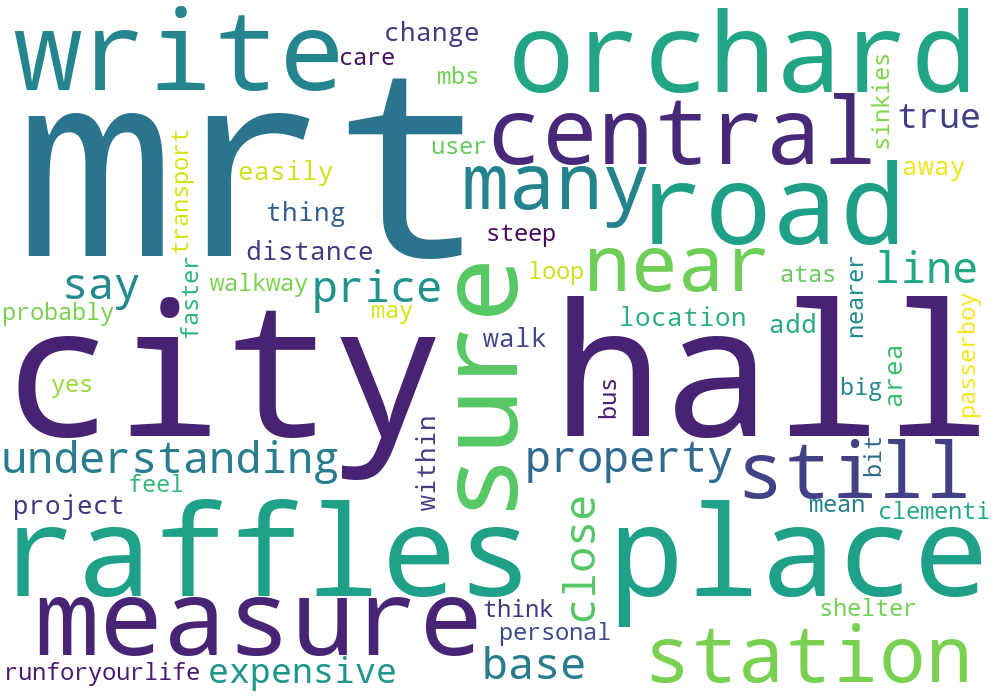

In [21]:
# Import the wordcloud library
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Join the different processed titles together.
long_string = ','.join(list(district_6_2019["post_text"].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", stopwords = STOPWORDS, width=1000, height=700, max_words=200, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

wordcloud.to_image()

We can see that the general impression of district 6 is "expensive", "atas", "near", "close"

In [22]:
import collections
filtered_words = [word for word in long_string.split() if word not in STOPWORDS]
counted_words = collections.Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(20):
    words.append(letter)
    counts.append(count)

<BarContainer object of 20 artists>

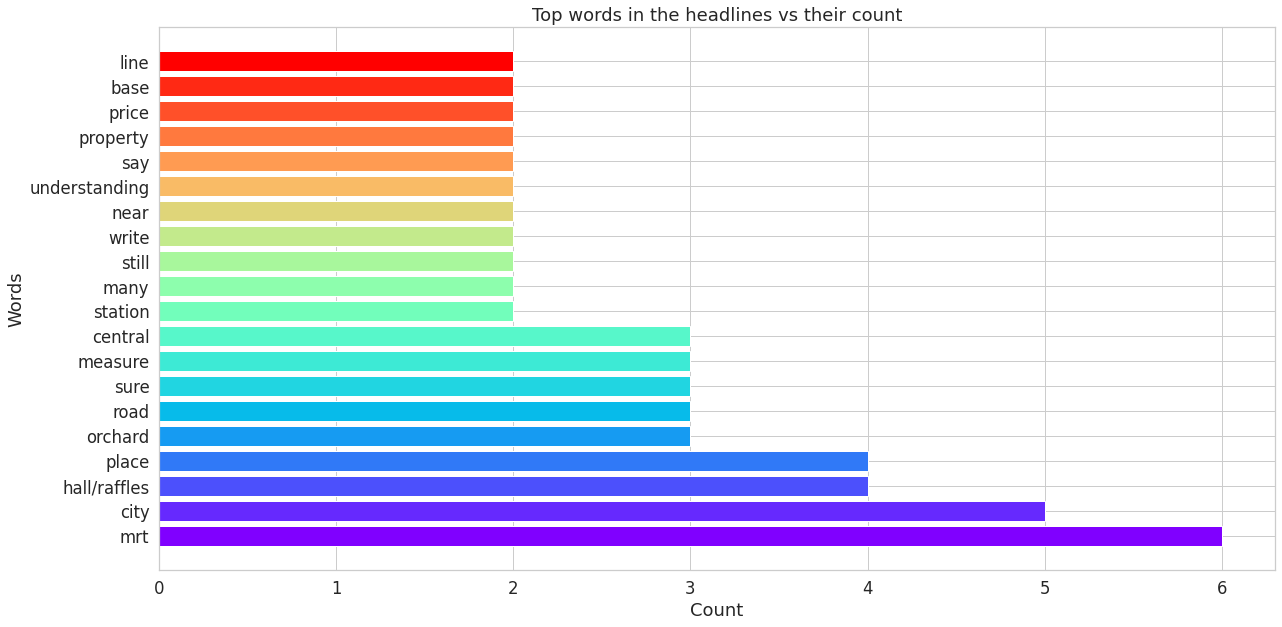

In [23]:
import matplotlib.cm as cm
from matplotlib import rcParams

colors = cm.rainbow(np.linspace(0, 1, 20))
rcParams['figure.figsize'] = 20, 10

plt.title('Top words in the headlines vs their count')
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(words, counts, color=colors)

In [24]:
sid = SentimentIntensityAnalyzer()
sentiment_top20 = []
for w in words:
  sentiment =  sid.polarity_scores(w)
  print(w , "Sentiment Polarity Score of:", sentiment)

mrt Sentiment Polarity Score of: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
city Sentiment Polarity Score of: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
hall/raffles Sentiment Polarity Score of: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
place Sentiment Polarity Score of: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
orchard Sentiment Polarity Score of: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
road Sentiment Polarity Score of: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
sure Sentiment Polarity Score of: {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.3182}
measure Sentiment Polarity Score of: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
central Sentiment Polarity Score of: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
station Sentiment Polarity Score of: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
many Sentiment Polarity Score of: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
still Sen

LDA wth Gensim for Topic Modelling

Text Cleaning for LDA

In [25]:
!pip install gensim

In [5]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = all_comments_relevant["post_text"].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['nishizhu', 'write', 'haha', 'yea', 'see', 'success', 'duo', 'residence', 'pple', 'buy', 'transact', 'park', 'place', 'another', 'mimic', 'ask', 'many', 'project', 'singapore', 'get', 'attribute', 'like', 'duo', 'plq', 'reason', 'certain', 'project', 'sell', 'last', 'check']


Using Gensim corpora to create a unique id for each word in the document

In [6]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 3), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


Building Base Model to get a baseline coherence score

In [59]:
# Build Base LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [60]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4423223113050083


Hyperparamter Tuning to find the optimum number of topics by setting fixed alpha and beta. We build many LDA models with different values of the number of topics (k) ranging from 2 to 12 and pick the one that gives the highest coherence value.




In [55]:
from gensim.models.ldamodel import LdaModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=num_topics, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

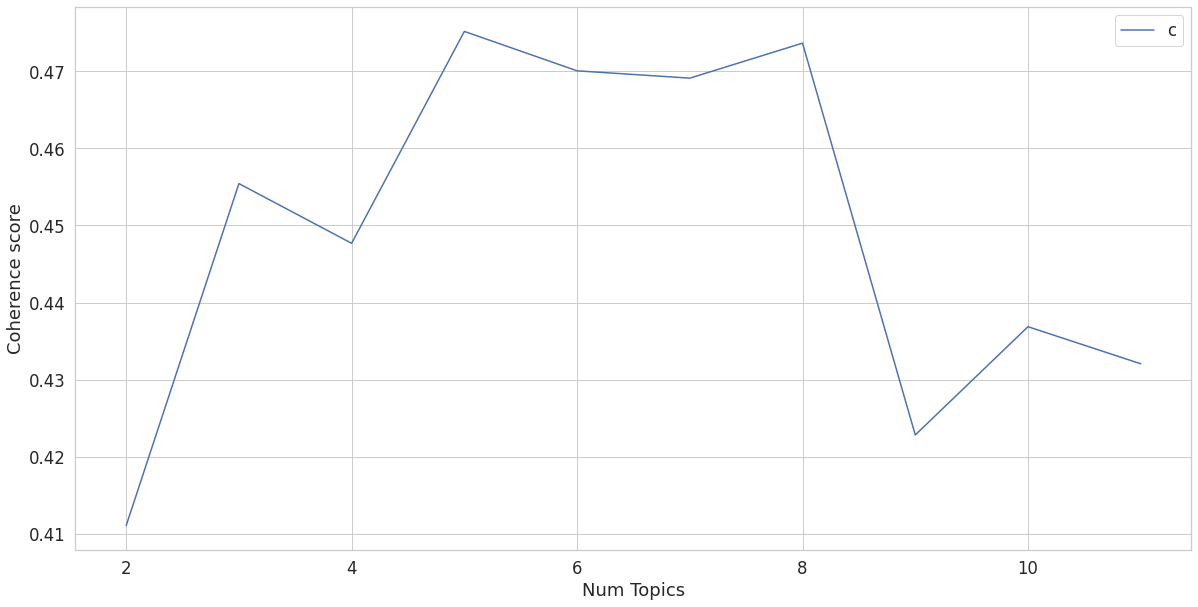

In [56]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, limit=12, start=2, step=1)

# Show graph
import matplotlib.pyplot as plt
limit=12; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [41]:
# # Build Final LDA model
# lda_model_final = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=6, 
#                                            random_state=100,
#                                            chunksize=100,
#                                            passes=10,
#                                            per_word_topics=True)

In [10]:
# Build Final LDA model
lda_model_final = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [11]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda_final = CoherenceModel(model=lda_model_final, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda_final = coherence_model_lda_final.get_coherence()
print('\nFinal Coherence Score: ', coherence_lda_final)


Final Coherence Score:  0.4814554631740392


Hyperparameter tuning including finding optimum alpha, beta and number of topic (Not used)

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
%%time
import numpy as np
import tqdm

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 3
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

 78%|██████████████████████████████████████████████████████████▎                | 420/540 [10:56:47<3:07:39, 93.83s/it]

Wall time: 10h 56min 47s


In [ ]:
pd.DataFrame(model_results).to_csv('lda_tuning_results_hwz.csv', index=False)

In [ ]:
lda_tuning_results_hwz = pd.read_csv('lda_tuning_results_hwz.csv')
lda_tuning_results_hwz


Validation_Set  Topics       Alpha                Beta  Coherence
0       75% Corpus       3        0.01                0.01   0.456196
1       75% Corpus       3        0.01                0.31   0.437414
2       75% Corpus       3        0.01                0.61   0.447141
3       75% Corpus       3        0.01  0.9099999999999999   0.439360
4       75% Corpus       3        0.01           symmetric   0.428780
..             ...     ...         ...                 ...        ...
415    100% Corpus       9  asymmetric                0.01   0.468002
416    100% Corpus       9  asymmetric                0.31   0.440559
417    100% Corpus       9  asymmetric                0.61   0.462997
418    100% Corpus       9  asymmetric  0.9099999999999999   0.484540
419    100% Corpus       9  asymmetric           symmetric   0.446660

[420 rows x 5 columns]

In [ ]:
lda_tuning_results_hwz.sort_values('Coherence',ascending = False).head(1)


Validation_Set  Topics               Alpha  Beta  Coherence
405    100% Corpus       9  0.9099999999999999  0.01   0.494723

Visualizing LDA model results using pyLDAvis

In [ ]:
!pip install pyLDAvis

In [12]:
# Visualize the topics
import pickle 
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_final, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.047974  0.060906       1        1  32.939628
3     -0.030508 -0.087449       2        1  29.508205
2     -0.254584  0.161106       3        1  16.139995
1      0.030014 -0.300503       4        1  11.239877
0      0.303052  0.165940       5        1  10.172296, topic_info=       Term          Freq         Total Category  logprob  loglift
242    unit  15627.000000  15627.000000  Default  30.0000  30.0000
4194     ec   6119.000000   6119.000000  Default  29.0000  29.0000
44     sell   7235.000000   7235.000000  Default  28.0000  28.0000
471     bto   5724.000000   5724.000000  Default  27.0000  27.0000
133   price  13397.000000  13397.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
1034  offer   1032.086191   2267.357993   Topic5  -4.9676   1.4985
578     may   1252.198817   4206.281441   Topic5  -4.7742   1.0738
21     last   1236.480881   4840.421857   Topic5  -4.7869   0.9208
917   first   1041.535900   3791.968114   Topic5  -4.9585   0.9933
478     hdb   1055.188089   6114.070373   Topic5  -4.9454   0.5286

[345 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
811       1  0.066987        abt
811       4  0.895638        abt
811       5  0.037215        abt
621       2  0.997999     accord
5477      5  0.994967  admiralty
...     ...       ...        ...
4541      1  0.233949     yishun
4541      2  0.022546     yishun
4541      3  0.342999     yishun
4541      5  0.400543     yishun
902       1  0.999036        yup

[549 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 2, 1])

Sentiment Analysis using Textblob


In [ ]:
#Getting comments from 2018 to 2021
year_2018 = all_comments_relevant[all_comments_relevant['timestamp'].str.contains("2018")] 
year_2019 = all_comments_relevant[all_comments_relevant['timestamp'].str.contains("2019")] 
year_2020 = all_comments_relevant[all_comments_relevant['timestamp'].str.contains("2020")] 
year_2021 = all_comments_relevant[all_comments_relevant['timestamp'].str.contains("2021")]

In [ ]:
from textblob import TextBlob

# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    
    # use this line for Python 2 (avoids UnicodeDecodeError for some reviews)
    # blob = TextBlob(text.decode(encoding='utf-8'))
    
    # use this line instead for Python 3
    blob = TextBlob(text)
    
    # return the polarity
    return blob.sentiment.polarity

In [ ]:
year_2018['sentiment'] = year_2018.post_text.apply(detect_sentiment)

sns.set(rc={'figure.figsize':(15,10)}, font_scale=1.5, style='whitegrid')
sns.boxplot(x="district_num", y="sentiment", data=year_2018);

In [ ]:
year_2019['sentiment'] = year_2019.post_text.apply(detect_sentiment)

sns.set(rc={'figure.figsize':(15,10)}, font_scale=1.5, style='whitegrid')
sns.boxplot(x="district_num", y="sentiment", data=year_2019);

In [ ]:
year_2020['sentiment'] = year_2020.post_text.apply(detect_sentiment)

sns.set(rc={'figure.figsize':(15,10)}, font_scale=1.5, style='whitegrid')
sns.boxplot(x="district_num", y="sentiment", data=year_2020);

In [ ]:
year_2021['sentiment'] = year_2021.post_text.apply(detect_sentiment)

sns.set(rc={'figure.figsize':(15,10)}, font_scale=1.5, style='whitegrid')
sns.boxplot(x="district_num", y="sentiment", data=year_2021);

In [ ]:
#2018
comment_count_2018 = year_2018.groupby('district_num')['post_id'].nunique().sort_values(ascending=False)
comment_count_2018  = pd.DataFrame(comment_count_2018)
mean_district_sentiment_2018 = year_2018.groupby('district_num', as_index=False)['sentiment'].mean()

sentiment_2018 = mean_district_sentiment_2018.merge(comment_count_2018, on='district_num', how='left')
sentiment_2018.columns = ['district_num', 'sentiment', 'comment_count']
sentiment_2018['year'] = 2018

#2019
comment_count_2019 = year_2019.groupby('district_num')['post_id'].nunique().sort_values(ascending=False)
comment_count_2019  = pd.DataFrame(comment_count_2019)
mean_district_sentiment_2019 = year_2019.groupby('district_num', as_index=False)['sentiment'].mean()

sentiment_2019 = mean_district_sentiment_2019.merge(comment_count_2019, on='district_num', how='left')
sentiment_2019.columns = ['district_num', 'sentiment', 'comment_count']
sentiment_2019['year'] = 2019

#2020
comment_count_2020 = year_2020.groupby('district_num')['post_id'].nunique().sort_values(ascending=False)
comment_count_2020 = pd.DataFrame(comment_count_2020)
mean_district_sentiment_2020 = year_2020.groupby('district_num', as_index=False)['sentiment'].mean()

sentiment_2020 = mean_district_sentiment_2020.merge(comment_count_2020, on='district_num', how='left')
sentiment_2020.columns = ['district_num', 'sentiment', 'comment_count']
sentiment_2020['year'] = 2020

#2021
comment_count_2021 = year_2021.groupby('district_num')['post_id'].nunique().sort_values(ascending=False)
comment_count_2021 = pd.DataFrame(comment_count_2021)
mean_district_sentiment_2021 = year_2021.groupby('district_num', as_index=False)['sentiment'].mean()

sentiment_2021 = mean_district_sentiment_2021.merge(comment_count_2021, on='district_num', how='left')
sentiment_2021.columns = ['district_num', 'sentiment', 'comment_count']
sentiment_2021['year'] = 2021

sentiment_list = [sentiment_2018, sentiment_2019, sentiment_2020, sentiment_2021]  # List of your dataframes
hwz_sentiment = pd.concat(sentiment_list)


In [ ]:
#Select 3 random district and investigate how sentiment changes over time
trends_3_district = hwz_sentiment.loc[hwz_sentiment['district_num'].isin([3,15,22])]
trends_3_district
fig, ax = plt.subplots(figsize=(20, 10))
plt.rcParams["figure.figsize"] = (20,10)
ax.set_ylim(-1,1)

for i in trends_3_district.district_num.unique():
    trends_3_district[trends_3_district['district_num']==i].plot.line(x='year', y='sentiment', ax=ax, label='id = %s'%i)
plt.xticks(np.unique(trends_3_district.year),rotation=45)    
print("")


In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.rcParams["figure.figsize"] = (20,10)
ax.set_ylim(-1,1)
for i in hwz_sentiment.district_num.unique():
    hwz_sentiment[hwz_sentiment['district_num']==i].plot.line(x='year', y='sentiment', ax=ax, label='id = %s'%i)
plt.xticks(np.unique(hwz_sentiment.year),rotation=45)    
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
print("")

hwz_sentiment.to_csv("hwz_sentiment.csv", encoding='utf-8', index=False)

Sentiment analysis approach using Afinn

In [ ]:
afinn = Afinn()
afinn_scores = [afinn.score(text) for text in year_2018.post_text]

In [ ]:
afinn = Afinn()

In [ ]:
afinn_emo = Afinn(emoticons=True)

In [ ]:
# In terminal: pip install afinn
from afinn import Afinn

In [ ]:
year_2018['afinn'] = afinn_scores
year_2018[['sentiment', 'afinn', 'content']].head(10)